# MULTI-LABEL ML CLASSIFICATION NLP

Source code and approach: 
https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

Source dataset: 
https://www.kaggle.com/datasets/meetnaren/goodreads-best-books/data

source reference: https://towardsdatascience.com/keras-tell-me-the-genre-of-my-book-a417d213e3a1



## Data exploration 

In [1]:
import pandas as pd
df = pd.read_csv('../assets/multilabel_book_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             52478 non-null  object 
 1   series            23470 non-null  object 
 2   author            52478 non-null  object 
 3   rating            52478 non-null  float64
 4   description       51140 non-null  object 
 5   language          48672 non-null  object 
 6   isbn              52478 non-null  object 
 7   genres            52478 non-null  object 
 8   characters        52478 non-null  object 
 9   bookFormat        51005 non-null  object 
 10  edition           4955 non-null   object 
 11  pages             50131 non-null  object 
 12  publisher         48782 non-null  object 
 13  publishDate       51598 non-null  object 
 14  firstPublishDate  31152 non-null  object 
 15  awards            52478 non-null  object 
 16  numRatings        52478 non-null  int64 

In [2]:
# remove empty and duplicates
df = (df.query('genres != "[]"')
    .dropna(subset=['description'])
    .drop_duplicates('title')
    .drop_duplicates('description')
)

In [3]:
# remove non english descriptions
from langdetect import detect

def detect_language(description):
    try:
        return detect(description)
    except Exception as e:
        print(f"Error: {e}")
        return 'unknown'
    
df['Language_detect'] = df['description'].apply(detect_language)
df = df.query('Language_detect=="en"')

Error: No features in text.
Error: No features in text.
Error: No features in text.


In [4]:
df.genres.value_counts()

genres
['Fiction']                                                                                                                                                                        146
['Fantasy']                                                                                                                                                                        121
['Childrens']                                                                                                                                                                       87
['Nonfiction']                                                                                                                                                                      76
['Poetry']                                                                                                                                                                          71
                                                                              

In [5]:
df.head()

,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,bbeScore,bbeVotes,price,Language_detect
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9.78044E+12,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",2993816,30516,5.09,en
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9.78044E+12,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,2632233,26923,7.38,en
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,1E+13,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,...,07-11-1960,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",2269402,23328,NaN,en
3,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,1E+13,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",1983116,20452,NaN,en
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9.78032E+12,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,...,10-05-2005,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",1459448,14874,2.1,en


## data cleaning 

In [6]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [7]:
books = df[['title','description','genres']].copy()

In [8]:
from ast import literal_eval
books['genres'] = books['genres'].apply(literal_eval)
all_categories = sum(books['genres'], [])
print('numer of categories before cleaning', len(set(all_categories)))

numer of categories before cleaning 965


In [9]:
all_genres = nltk.FreqDist(all_categories) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [10]:
# remove categories with less than 100 counts
remove_books = all_genres_df.query('Count < 100')['Genre'].tolist()
books['new_genres'] = books['genres'].apply(lambda genre_list: [genre for genre in genre_list if genre not in remove_books])
books = books.dropna(subset=['new_genres','description'])
all_new_genres = sum(books['new_genres'], [])
print(f"number of genres after cleaning:",len(set(all_new_genres)))

number of genres after cleaning: 295


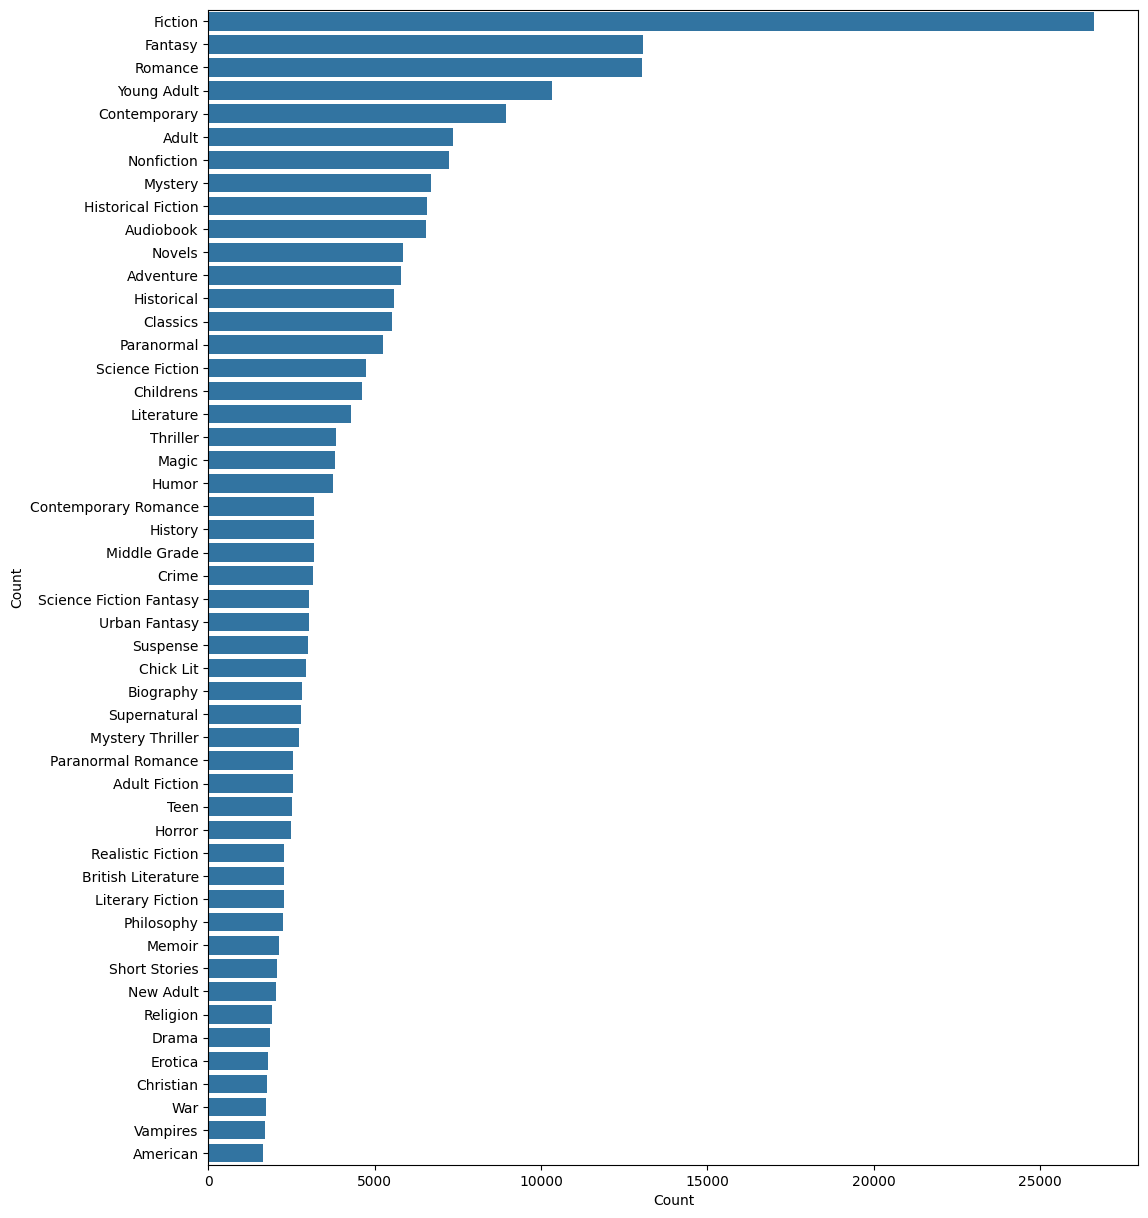

In [11]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()


## data pre-processing 

In [12]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text
books['description'] = books['description'].apply(lambda x: clean_text(x))


In [13]:
books.sample(3)


,title,description,genres,new_genres
19322,Invasion of the Overworld: A Minecraft Novel,gameknight loved minecraft reveled in building fabulous structures playing on servers creating custom maps but most of all he loved to grief as the self proclaimed king of the griefers gameknight played the game for himself at the expense of everyone else keeping the list of his friends in the g...,"[Childrens, Fantasy, Adventure, Fiction, Young Adult, Science Fiction, Middle Grade, Action, Monsters, Gaming]","[Childrens, Fantasy, Adventure, Fiction, Young Adult, Science Fiction, Middle Grade, Action]"
16840,Tahn,in a dark medieval land good and evil battle it out trapped between his masters evil commands and his persistent conscience that tells him to do otherwise tahn dorn finds himself in a twisting plot that threatens not only his life but also that of the lovely netta,"[Fantasy, Christian Fiction, Christian, Fiction, Historical Fiction, Romance, Christian Fantasy, Historical, Medieval, Adult]","[Fantasy, Christian Fiction, Christian, Fiction, Historical Fiction, Romance, Historical, Medieval, Adult]"
20673,Come - Travel With Me: 10 Droplets,come travel with me is a memoir author is seeking to get readers to wander with him this book delivers ten chapters ten droplets display that each droplet will lift you to flourish in the upbringing author encountered frist writing experience he had is dreadful that could have wiped out his desi...,[Nonfiction],[Nonfiction]


In [14]:
# remove stopwords

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['clean_descriptiont'] = books['description'].apply(lambda x: remove_stopwords(x))


In [15]:
# genres to features - VECTORIZATION
import pickle 
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(books['new_genres'])

# transform target variable
y = multilabel_binarizer.transform(books['new_genres'])

# store vectoriser for later 
pickle.dump(multilabel_binarizer, open("../assets/multilabel_binarizer.pickle", "wb"))

In [16]:
y.shape

(39814, 295)

In [17]:
xtrain, xval, ytrain, yval = train_test_split(books['clean_descriptiont'], y, test_size=0.2, random_state=9)

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

pickle.dump(tfidf_vectorizer, open("../assets/tfidf_vectorizer.pickle", "wb"))

In [19]:
# Train ML model 

In [20]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

lr = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0])

In [21]:
# save model
pickle.dump(clf, open("../assets/ML2", "wb"))

In [22]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Contemporary', 'Fiction', 'Romance', 'Young Adult')

In [23]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.46050104562331945

In [24]:
# predict probabilities
y_pred = clf.predict(xval_tfidf)

In [25]:
# see prediction on test data
results = pd.DataFrame(xval)
results['genre_predicted'] = multilabel_binarizer.inverse_transform(y_pred)
results.merge(books[['title', 'genres']], left_index=True, right_index=True)

,clean_descriptiont,genre_predicted,title,genres
32010,happens girl loved since six years old runs away effectively breaking heart evan find nineteen year old evan spends time woods dare forest trees personality close abby love cruel master everyone around forbidden contact abby nights stressed enchanter life dreaded nightmares enduring save brother...,"(Contemporary, Romance, Young Adult)",Emerald Destiny,"[Fantasy, Romance]"
14923,father gregory boyle sparkling parables kinship sacredness life drawn twenty years working gangs la fight despair learn meet world loving heart overcome shame stay faithful spite failure matter people live circumstances may everyone needs boundless restorative love gorgeous uplifting tattoos hea...,"(Nonfiction,)",Tattoos on the Heart: The Power of Boundless Compassion,"[Nonfiction, Memoir, Faith, Religion, Christian, Spirituality, Audiobook, Biography, Christianity, Social Justice]"
17228,wsj bestselling author ilsa madden mills delivers gripping enemies lovers secret admirer high school romance rich popular sharks rule prestigious ivy covered camden prep upon time wanted part world destroyed last thing expected anonymous love letter one please hate every one rich jerks question ...,"(Contemporary, Contemporary Romance, New Adult, Romance)",Dear Ava,"[Romance, New Adult, High School, Contemporary, Sports, Contemporary Romance, Young Adult, Sports Romance, Abuse, College]"
38828,poor noah grimes dad disappeared years ago mothers beyonce tribute act unacceptable embarrassment beloved gran isnt anymore one friend harry school well pure hell cant noah normal like everyone else school maybe struck romantic relationship someone maybe sophie perfect lovely hed seen different ...,"(Contemporary, Fiction, Romance, Young Adult)",Noah Can't Even,"[LGBT, Young Adult, Contemporary, Romance, Queer, Fiction, M M Romance, Gay, Humor, Young Adult Contemporary]"
16273,everyone knows chelsea knot cant keep secretuntil last secret shared turned social outcast nearly got someone killed chelsea taken vow silence learn keep mouth shut stop hurting anyone else thinks keeping secrets hard speaking shes ignored ridiculed even attacked worse theres strength silence ne...,"(Contemporary, Fiction, Romance, Young Adult)",Speechless,"[Young Adult, Contemporary, Romance, Realistic Fiction, Fiction, Young Adult Contemporary, High School, LGBT, Chick Lit, Teen]"
...,...,...,...,...
47616,woeful second world war presents dire details war affected almost everyone old men joining dads army year olds defending berlin bitter end find made meal maggots soldiers smelly enemies could sniff,"(Historical, War)",The Woeful Second World War,"[History, Nonfiction, Childrens, Historical, Humor, War, World War II, Comedy, British Literature, 20th Century]"
2787,ben carson saved pregnant wife anne ultimate evil summer future looks great ben anne son taylor married longtime love jenny expecting first grandchild daughter molly almost seventeen beautiful intelligent teenager life never better carson family change disturbing dreams back ben terrified ultima...,"(Fantasy, Fiction)",The Well House II: The Revenge,"[Fiction, Contemporary, Drama, Epic, Novels]"
41201,sometimes touch things words fill head words feel like thoughts thoughts inside mine used think crazy used im starting wonder theres reason voices tangle together mind im right sanity im worried life,"(Contemporary, Fiction, Romance, Young Adult)",Gifted Touch,"[Young Adult, Paranormal, Fantasy, Mystery, Science Fiction, Teen, Supernatural, Fiction, Romance, Urban Fantasy]"
17201,wintles little wonders cora wintle goes pick orphaned niece rachel discovers rachels adopted sister hilary would perfect dancing troupe problem hilary might good precious daughter dulcie still shes determined take sulky rachel sprightly hilary make little wonders rachel doesnt want little wonder...,"(Childrens, Fiction, Romance, Young Adult)",Dancing Shoes,"[Childrens, Fiction, Classics, Middle Grade, Young Adult, H

# Program 

In [26]:
import pandas as pd

In [27]:
# function for text cleaning 
import re
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)



In [28]:
# load vectoriser, multilabel Binarizer and the model 
import pickle
tfidf_vectorizer = pickle.load(open("../assets/tfidf_vectorizer.pickle", "rb"))
loaded_model = pickle.load(open("../assets/ML2", "rb"))
multilabel_binarizer = pickle.load(open("../assets/multilabel_binarizer.pickle", "rb"))

In [29]:
from ast import literal_eval
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = loaded_model.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [30]:
mybooks = pd.read_pickle('../assets/my_books.pkl')
mybooks = mybooks.query('Description.notna()')

# remove non english
from langdetect import detect
mybooks['Language_detect'] = mybooks['Description'].apply(detect)
mybooks = (
    mybooks.query('Language_detect=="en"')
    .drop(columns=['Language_detect'])
    )

In [31]:
for i in range(50): 
  k = mybooks.sample(1).index[0]
  print("Movie: ", mybooks['Title'][k], "\nPredicted genre: ", infer_tags(mybooks['Description'][k]))

Movie:  I'm a Fan 
Predicted genre:  [('Contemporary', 'Fiction')]
Movie:  Bellies 
Predicted genre:  [('Contemporary', 'Fiction')]
Movie:  The Firm (The Firm, #1) 
Predicted genre:  [('Crime', 'Fiction', 'Mystery', 'Mystery Thriller', 'Suspense', 'Thriller')]
Movie:  Visual Intelligence: Sharpen Your Perception, Change Your Life 
Predicted genre:  [('Nonfiction',)]
Movie:  Memoirs of a Geisha 
Predicted genre:  [('Fiction', 'Historical Fiction', 'Novels')]
Movie:  Small Pleasures 
Predicted genre:  [('Fiction', 'Historical Fiction')]
Movie:  Free Lunch Thinking: How Economics Ruins the Economy 
Predicted genre:  [('History', 'Nonfiction', 'Politics')]
Movie:  Daisy Darker 
Predicted genre:  [('Audiobook', 'Fiction', 'Mystery', 'Mystery Thriller', 'Suspense', 'Thriller')]
Movie:  Dominicana 
Predicted genre:  [('Contemporary', 'Fiction', 'Romance')]
Movie:  Black Mountain 
Predicted genre:  [('Fantasy', 'Fiction', 'Young Adult')]
Movie:  The Sympathizer 
Predicted genre:  [('Fiction', 

In [32]:
# predict genre and add it to a new column "genres"
mybooks['genres'] = mybooks['Description'].apply(infer_tags)

def makelist(list1):
    return str(list1).replace('(','').replace(')','').replace(',]',']')

mybooks['genres'] = mybooks['genres'].apply(makelist)


In [33]:
mybooks[['Title','genres']].sample(50)

,Title,genres
154,The Guest Cat,"['Contemporary', 'Fiction', 'Literature', 'Novels']"
336,"The Unhoneymooners (Unhoneymooners, #1)","['Adult', 'Contemporary', 'Fiction', 'Humor', 'Romance']"
171,The Bread the Devil Knead,"['Adult', 'Contemporary', 'Fiction', 'Romance']"
222,My Year of Rest and Relaxation,"['Contemporary', 'Fiction']"
15,A Tale for the Time Being,"['Contemporary', 'Fiction', 'Literary Fiction', 'Novels']"
78,Happy Place,"['Adult', 'Chick Lit', 'Contemporary', 'Contemporary Romance', 'Fiction', 'Romance']"
351,Fiesta: The Sun Also Rises,['Fiction']
150,"Yinka, Where Is Your Huzband?","['Adult', 'Chick Lit', 'Contemporary', 'Fiction', 'Humor', 'Romance']"
292,Why We Sleep: Unlocking the Power of Sleep and Dreams,['Nonfiction']
191,The Story of My Teeth,['Fiction']


In [34]:
pd.to_pickle(mybooks, '../assets/my_books_genres.pickle')